In [2]:
import cv2
import numpy as np
import os

def load_images_from_folder(folder):
    images = []
    labels = [] 
    for label in os.listdir(folder):
        path = os.path.join(folder, label)
        if os.path.isdir(path):
            for filename in os.listdir(path):
                img_path = os.path.join(path, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    img_resized = cv2.resize(img, (128, 128))
                    images.append(img_resized)
                    labels.append(label)
    return np.array(images), np.array(labels)

train_images, train_labels = load_images_from_folder('/kaggle/input/cars-image-dataset/Cars Dataset/train')
test_images, test_labels = load_images_from_folder('/kaggle/input/cars-image-dataset/Cars Dataset/test')


In [3]:
import tensorflow as tf
import warnings
warnings.filterwarnings('ignore')


print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available")


2024-04-29 23:43:42.277021: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-29 23:43:42.277137: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-29 23:43:42.405015: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Num GPUs Available:  1
GPU is available


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_images(images, labels, nrows=4, ncols=4):
    fig, axes = plt.subplots(nrows, ncols, figsize=(10, 10))
    axes = axes.flatten()
    
    indices = np.random.choice(len(images), nrows * ncols, replace=False)
    
    for idx, ax in zip(indices, axes):
        img = images[idx]
        if img.dtype != np.uint8:  
            img = (img * 255).astype('uint8')

        if img.shape[2] == 3:  
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        ax.imshow(img)
        ax.set_title(labels[idx])
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

plot_images(train_images, train_labels, nrows=4, ncols=4)


In [5]:
train_images = train_images / 255.0
test_images = test_images / 255.0

from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_labels)
train_labels_one_hot = to_categorical(train_labels_encoded)
test_labels_encoded = label_encoder.transform(test_labels)
test_labels_one_hot = to_categorical(test_labels_encoded)

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2, l1
from tensorflow.keras.optimizers import Adam, Adamax

def build_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(128, 128, 3), kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.2),

        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l1(0.0001)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.3),
        
        Flatten(),

        Dense(1024, activation='relu', kernel_regularizer=l1(0.0001)),
        Dropout(0.5),
        
        Dense(32, activation='relu', kernel_regularizer=l1(0.0001)),
        
        Dense(units=7, activation='softmax')
    ])
    
    model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [ ]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import label_binarize
from tensorflow.keras.utils import to_categorical

def calculate_metrics(y_test, y_score, num_classes):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    precision = dict()
    recall = dict()
    pr_auc = dict()

    y_test = label_binarize(y_test, classes=np.arange(num_classes))

    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
        pr_auc[i] = auc(recall[i], precision[i])

    return fpr, tpr, roc_auc, precision, recall, pr_auc

In [ ]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % 5 == 0: 
            print(f"Epoch {epoch+1}: accuracy = {logs['accuracy']:.4f}, loss = {logs['loss']:.4f}, val_accuracy = {logs['val_accuracy']:.4f}, val_loss = {logs['val_loss']:.4f}")


In [ ]:
from sklearn.model_selection import StratifiedKFold
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import confusion_matrix

X = train_images
y = np.argmax(train_labels_one_hot, axis=1)

n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
num_classes = 7
accumulated_cm = np.zeros((7, 7), dtype=int)  

val_loss_history = []  
train_loss_history = []

val_accuracy_history = [] 
train_accuracy_history = []

all_fpr = []
all_tpr = []
all_precision = []
all_recall = []

metrics_results = {
    'accuracy': [],
    'recall': [],
    'precision': [],
    'f1': [],
    'auc': []
}


fold_no = 1
for train_index, test_index in skf.split(X, y):
    X_train_fold, X_test_fold = X[train_index], X[test_index]
    y_train_fold, y_test_fold = y[train_index], y[test_index]
    y_train_fold_onehot = to_categorical(y_train_fold, num_classes=np.max(y)+1)
    y_test_fold_onehot = to_categorical(y_test_fold, num_classes=np.max(y)+1)


    model = build_model()

    print(f'Training for fold {fold_no}...')
    history = model.fit(X_train_fold, y_train_fold_onehot, epochs=70, validation_data=(X_test_fold, y_test_fold_onehot), callbacks=[CustomCallback()], verbose=0)
    
    y_pred_prob = model.predict(X_test_fold)
    y_pred = np.argmax(y_pred_prob, axis=1)

    val_loss_history.append(history.history['val_loss'])
    train_loss_history.append(history.history['loss'])
    val_accuracy_history.append(history.history['val_accuracy'])  
    train_accuracy_history.append(history.history['accuracy']) 
    
    y_pred_prob = model.predict(X_test_fold)
    y_pred = np.argmax(y_pred_prob, axis=1)

    fpr, tpr, roc_auc, precision, recall, pr_auc = calculate_metrics(y_test_fold, y_pred_prob, num_classes)
    all_fpr.append(fpr)
    all_tpr.append(tpr)
    all_precision.append(precision)
    all_recall.append(recall)
    
    metrics_results['accuracy'].append(accuracy_score(y_test_fold, y_pred))
    metrics_results['recall'].append(recall_score(y_test_fold, y_pred, average='macro'))
    metrics_results['precision'].append(precision_score(y_test_fold, y_pred, average='macro'))
    metrics_results['f1'].append(f1_score(y_test_fold, y_pred, average='macro'))
    metrics_results['auc'].append(roc_auc_score(y_test_fold_onehot, y_pred_prob, multi_class='ovr'))

    
    cm = confusion_matrix(y_test_fold, y_pred)
    accumulated_cm += cm

    fold_no += 1

Training for fold 1...


2024-04-29 23:44:08.317820: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31758: 7.18885, expected 6.34915
2024-04-29 23:44:08.317890: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31794: 6.79032, expected 5.95062
2024-04-29 23:44:08.317900: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31795: 6.91364, expected 6.07395
2024-04-29 23:44:08.317908: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31796: 7.21123, expected 6.37153
2024-04-29 23:44:08.317916: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31809: 7.14567, expected 6.30597
2024-04-29 23:44:08.317924: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31823: 7.30269, expected 6.46299
2024-04-29 23:44:08.317932: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 31824: 7.17199, expected 6.33229
2024-04-29 23:44:08.317941:

Epoch 5: accuracy = 0.3790, loss = 3.5117, val_accuracy = 0.3601, val_loss = 3.6441
Epoch 10: accuracy = 0.4904, loss = 3.1090, val_accuracy = 0.4286, val_loss = 3.3084
Epoch 15: accuracy = 0.5822, loss = 2.7496, val_accuracy = 0.4226, val_loss = 3.0995
Epoch 20: accuracy = 0.6316, loss = 2.4505, val_accuracy = 0.5565, val_loss = 2.6018
Epoch 25: accuracy = 0.7089, loss = 2.1988, val_accuracy = 0.6042, val_loss = 2.4154
Epoch 30: accuracy = 0.7480, loss = 2.0192, val_accuracy = 0.6220, val_loss = 2.2354
Epoch 35: accuracy = 0.7775, loss = 1.8440, val_accuracy = 0.6637, val_loss = 2.0925
Epoch 40: accuracy = 0.8090, loss = 1.7122, val_accuracy = 0.6935, val_loss = 1.9970
Epoch 45: accuracy = 0.8468, loss = 1.5735, val_accuracy = 0.7232, val_loss = 1.8922
Epoch 50: accuracy = 0.8687, loss = 1.4636, val_accuracy = 0.7113, val_loss = 1.8644
Epoch 55: accuracy = 0.8820, loss = 1.3888, val_accuracy = 0.7381, val_loss = 1.8106
Epoch 60: accuracy = 0.8995, loss = 1.2912, val_accuracy = 0.7560,

2024-04-29 23:47:56.132096: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15882: 6.22994, expected 5.50299
2024-04-29 23:47:56.132160: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15906: 5.99106, expected 5.2641
2024-04-29 23:47:56.132171: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15918: 6.20212, expected 5.47516
2024-04-29 23:47:56.132180: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15919: 5.7922, expected 5.06524
2024-04-29 23:47:56.132199: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15937: 5.3571, expected 4.63015
2024-04-29 23:47:56.132208: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15947: 6.08377, expected 5.35682
2024-04-29 23:47:56.132217: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 15954: 6.20606, expected 5.47911
2024-04-29 23:47:56.132226: E 

Epoch 5: accuracy = 0.3968, loss = 3.5283, val_accuracy = 0.3224, val_loss = 3.7250
Epoch 10: accuracy = 0.5051, loss = 3.1446, val_accuracy = 0.5194, val_loss = 3.2263
Epoch 15: accuracy = 0.5774, loss = 2.8077, val_accuracy = 0.5522, val_loss = 2.8679
Epoch 20: accuracy = 0.6374, loss = 2.5313, val_accuracy = 0.5672, val_loss = 2.7414
Epoch 25: accuracy = 0.6947, loss = 2.2909, val_accuracy = 0.6239, val_loss = 2.5441
Epoch 30: accuracy = 0.7332, loss = 2.0724, val_accuracy = 0.6567, val_loss = 2.4090
Epoch 35: accuracy = 0.7806, loss = 1.8870, val_accuracy = 0.6955, val_loss = 2.2858
Epoch 40: accuracy = 0.8114, loss = 1.7577, val_accuracy = 0.7104, val_loss = 2.1617
Epoch 45: accuracy = 0.8459, loss = 1.6130, val_accuracy = 0.7075, val_loss = 2.1266
Epoch 50: accuracy = 0.8651, loss = 1.5005, val_accuracy = 0.7194, val_loss = 2.0733
Epoch 55: accuracy = 0.8827, loss = 1.4116, val_accuracy = 0.7313, val_loss = 2.0506
Epoch 60: accuracy = 0.8906, loss = 1.3392, val_accuracy = 0.7045,

In [ ]:
print("Average Metrics Across All Folds:")
for metric, values in metrics_results.items():
    print(f"{metric}: {np.mean(values):.4f}")


Average Metrics Across All Folds:
accuracy: 0.7506
recall: 0.7089
precision: 0.7350
f1: 0.7160
auc: 0.9428


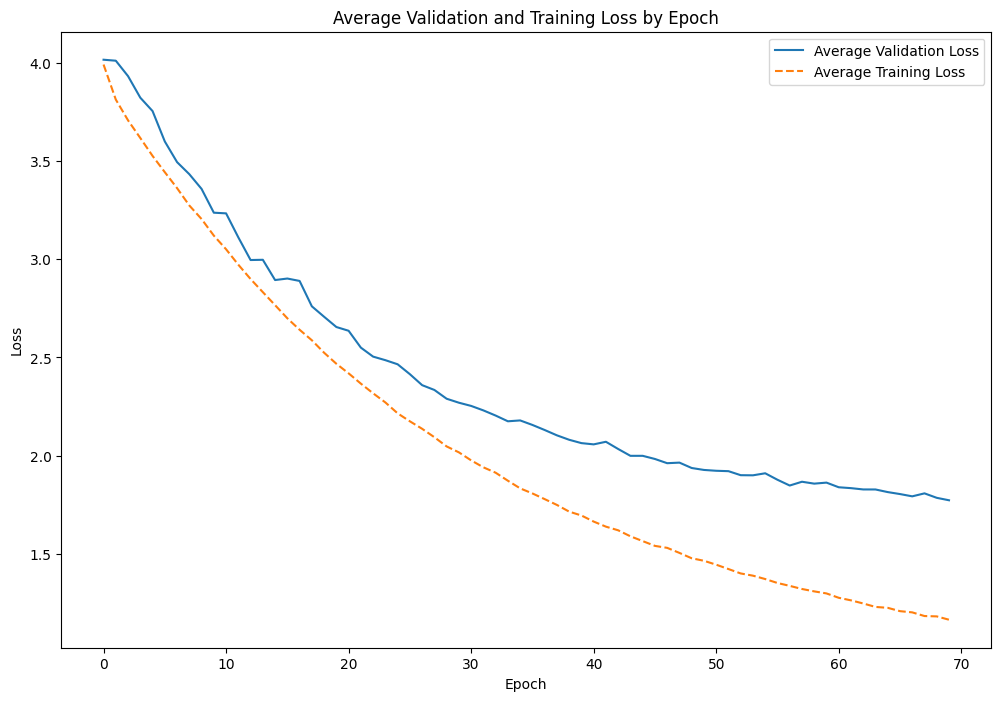

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_loss(val_loss_history, train_loss_history):
    plt.figure(figsize=(12, 8))

    avg_val_loss = np.mean(val_loss_history, axis=0)
    avg_train_loss = np.mean(train_loss_history, axis=0)

    plt.plot(avg_val_loss, label='Average Validation Loss')
    plt.plot(avg_train_loss, label='Average Training Loss', linestyle='--')

    plt.title('Average Validation and Training Loss by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(val_loss_history, train_loss_history)


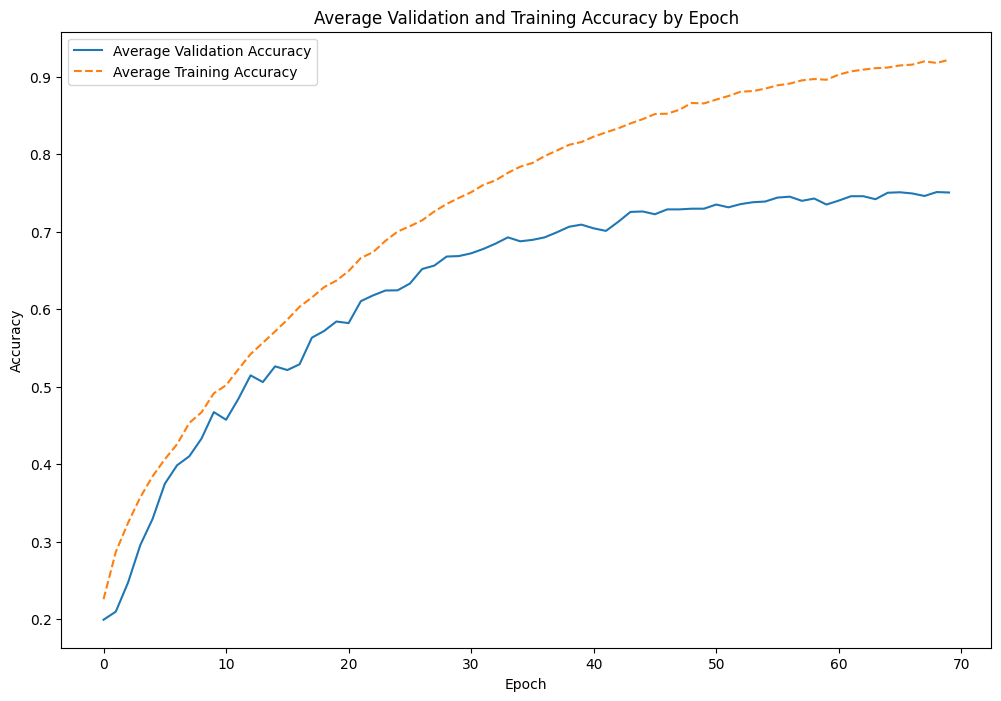

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_accuracy(val_accuracy_history, train_accuracy_history):
    plt.figure(figsize=(12, 8))

    avg_val_accuracy = np.mean(val_accuracy_history, axis=0)
    avg_train_accuracy = np.mean(train_accuracy_history, axis=0)

    plt.plot(avg_val_accuracy, label='Average Validation Accuracy')
    plt.plot(avg_train_accuracy, label='Average Training Accuracy', linestyle='--')

    plt.title('Average Validation and Training Accuracy by Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy(val_accuracy_history, train_accuracy_history)


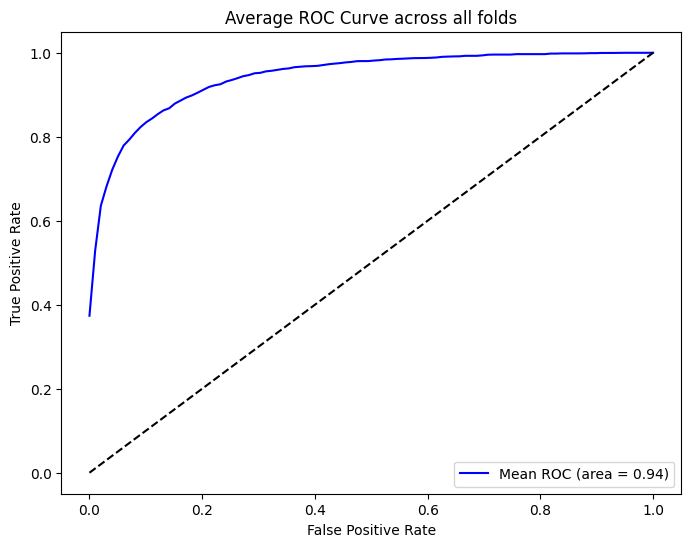

In [ ]:
from scipy import interp
from numpy import linspace

def plot_average_roc(all_fpr, all_tpr, num_classes):
    mean_fpr = linspace(0, 1, 100)
    
    mean_tpr = np.zeros_like(mean_fpr)
    for fpr, tpr in zip(all_fpr, all_tpr):
        for i in range(num_classes):
            mean_tpr += interp(mean_fpr, fpr[i], tpr[i])
    
    mean_tpr /= (len(all_fpr) * num_classes)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_fpr, mean_tpr, color='blue',
             label=f'Mean ROC (area = {auc(mean_fpr, mean_tpr):.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Average ROC Curve across all folds')
    plt.legend(loc='lower right')
    plt.show()

plot_average_roc(all_fpr, all_tpr, num_classes)

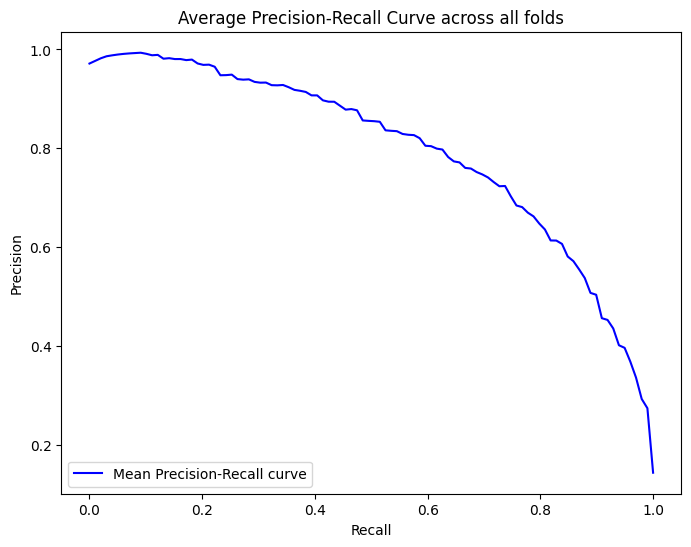

In [ ]:
def plot_average_precision_recall(all_precision, all_recall, num_classes):
    mean_recall = linspace(0, 1, 100)
    
    mean_precision = np.zeros_like(mean_recall)
    for precision, recall in zip(all_precision, all_recall):
        for i in range(num_classes):
            mean_precision += interp(mean_recall, recall[i][::-1], precision[i][::-1])
    
    mean_precision /= (len(all_precision) * num_classes)
    
    plt.figure(figsize=(8, 6))
    plt.plot(mean_recall, mean_precision, color='blue',
             label='Mean Precision-Recall curve')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Average Precision-Recall Curve across all folds')
    plt.legend(loc='lower left')
    plt.show()

plot_average_precision_recall(all_precision, all_recall, num_classes)


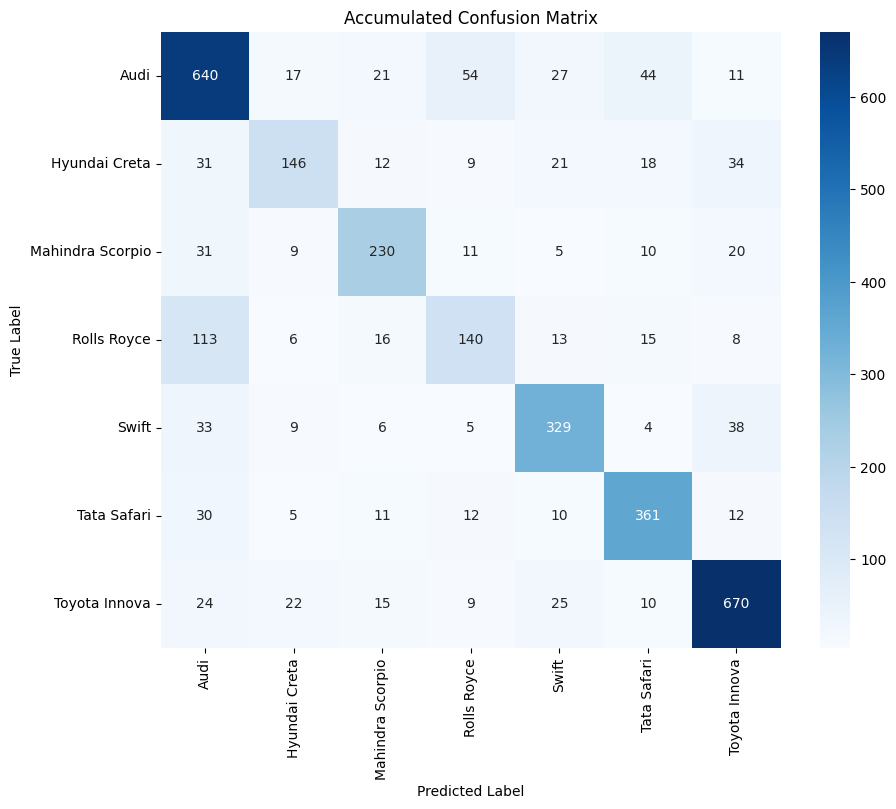

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes):
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
    plt.title('Accumulated Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

class_names = ['Audi', 'Hyundai Creta', 'Mahindra Scorpio', 'Rolls Royce', 'Swift', 'Tata Safari', 'Toyota Innova']
plot_confusion_matrix(accumulated_cm, class_names)


In [ ]:
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)


12/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 

2024-04-30 00:01:49.509811: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 179: 5.28614, expected 4.64663
2024-04-30 00:01:49.509874: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 450: 5.0653, expected 4.4258
2024-04-30 00:01:49.509905: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 549: 5.06694, expected 4.42744
2024-04-30 00:01:49.509918: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 550: 5.34534, expected 4.70584
2024-04-30 00:01:49.509930: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 551: 5.35632, expected 4.71682
2024-04-30 00:01:49.509944: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 552: 5.34166, expected 4.70216
2024-04-30 00:01:49.509965: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 590: 5.28539, expected 4.64588
2024-04-30 00:01:49.509983: E external/loca

26/26 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step


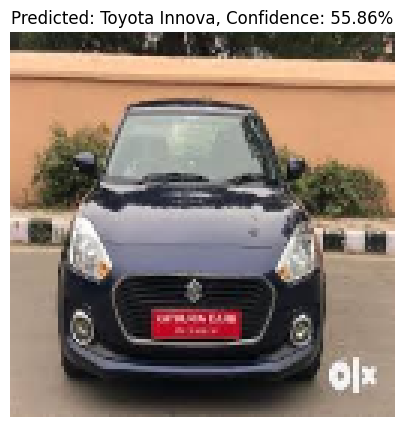

Predictions for each class:
Audi: 1.42%
Hyundai Creta: 3.35%
Mahindra Scorpio: 23.28%
Rolls Royce: 0.64%
Swift: 12.77%
Tata Safari: 2.67%
Toyota Innova: 55.86%




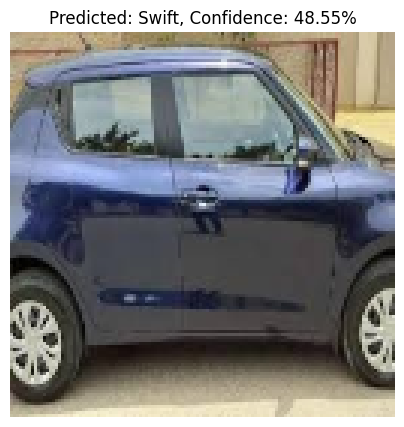

Predictions for each class:
Audi: 0.00%
Hyundai Creta: 0.42%
Mahindra Scorpio: 12.66%
Rolls Royce: 0.45%
Swift: 48.55%
Tata Safari: 0.02%
Toyota Innova: 37.89%




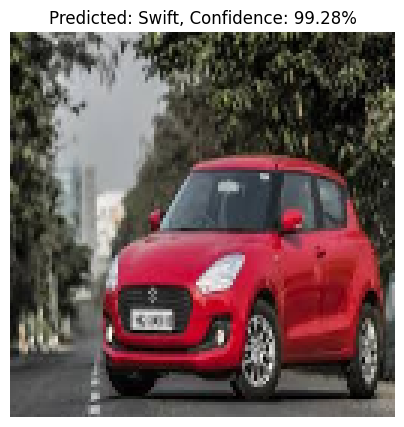

Predictions for each class:
Audi: 0.00%
Hyundai Creta: 0.10%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.00%
Swift: 99.28%
Tata Safari: 0.00%
Toyota Innova: 0.61%




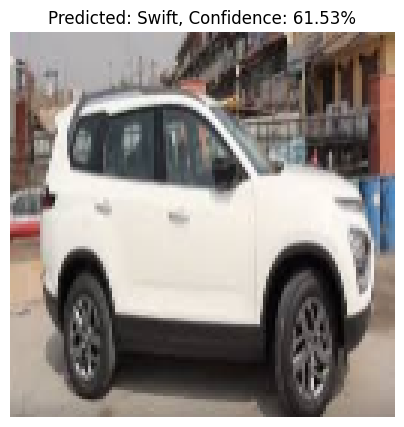

Predictions for each class:
Audi: 0.01%
Hyundai Creta: 8.49%
Mahindra Scorpio: 1.66%
Rolls Royce: 0.20%
Swift: 61.53%
Tata Safari: 0.02%
Toyota Innova: 28.10%




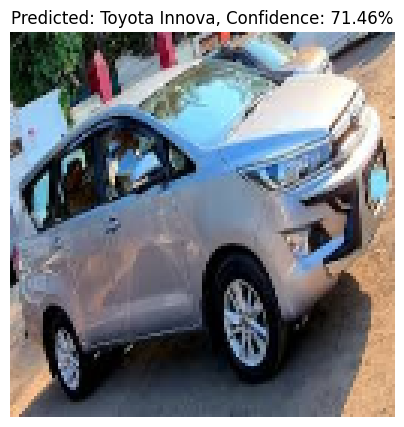

Predictions for each class:
Audi: 0.13%
Hyundai Creta: 1.33%
Mahindra Scorpio: 7.65%
Rolls Royce: 0.86%
Swift: 18.27%
Tata Safari: 0.30%
Toyota Innova: 71.46%




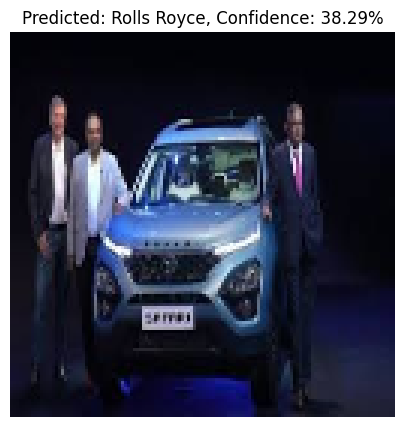

Predictions for each class:
Audi: 25.35%
Hyundai Creta: 6.68%
Mahindra Scorpio: 1.12%
Rolls Royce: 38.29%
Swift: 2.47%
Tata Safari: 25.53%
Toyota Innova: 0.55%




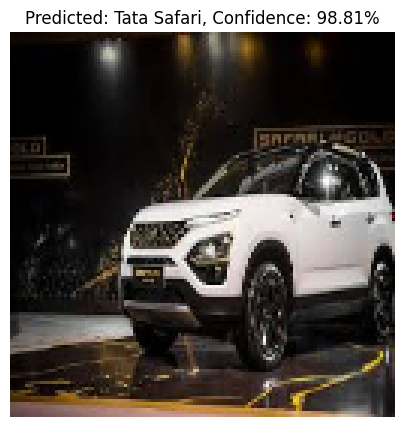

Predictions for each class:
Audi: 0.15%
Hyundai Creta: 0.03%
Mahindra Scorpio: 0.08%
Rolls Royce: 0.91%
Swift: 0.01%
Tata Safari: 98.81%
Toyota Innova: 0.00%




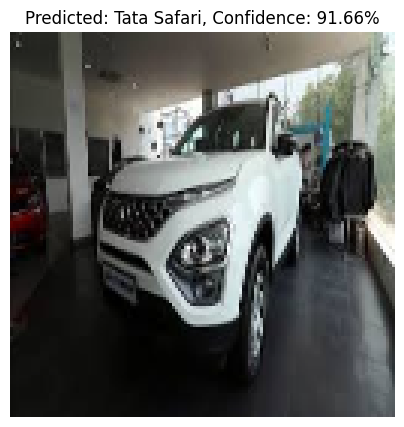

Predictions for each class:
Audi: 2.74%
Hyundai Creta: 2.00%
Mahindra Scorpio: 2.01%
Rolls Royce: 1.32%
Swift: 0.17%
Tata Safari: 91.66%
Toyota Innova: 0.10%




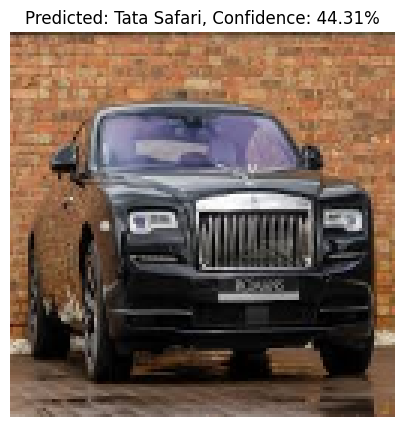

Predictions for each class:
Audi: 33.72%
Hyundai Creta: 0.07%
Mahindra Scorpio: 20.91%
Rolls Royce: 0.96%
Swift: 0.00%
Tata Safari: 44.31%
Toyota Innova: 0.03%




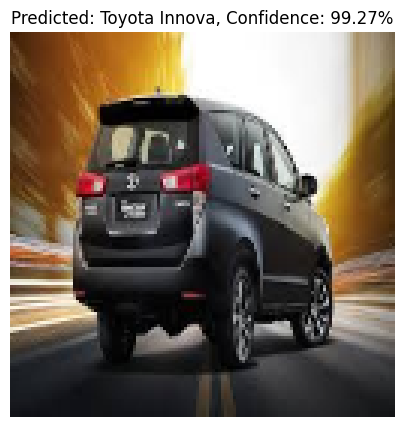

Predictions for each class:
Audi: 0.01%
Hyundai Creta: 0.13%
Mahindra Scorpio: 0.49%
Rolls Royce: 0.05%
Swift: 0.05%
Tata Safari: 0.01%
Toyota Innova: 99.27%




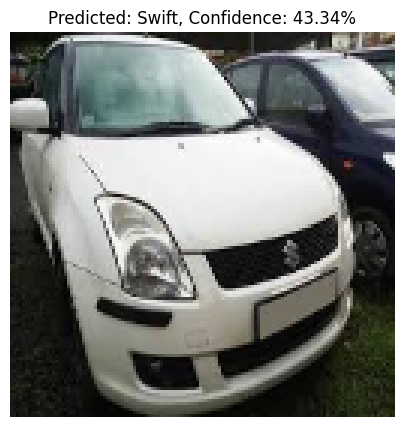

Predictions for each class:
Audi: 0.39%
Hyundai Creta: 33.01%
Mahindra Scorpio: 0.57%
Rolls Royce: 0.53%
Swift: 43.34%
Tata Safari: 0.42%
Toyota Innova: 21.74%




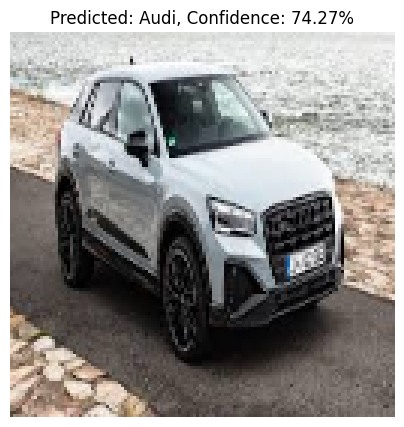

Predictions for each class:
Audi: 74.27%
Hyundai Creta: 5.21%
Mahindra Scorpio: 0.55%
Rolls Royce: 6.33%
Swift: 0.04%
Tata Safari: 13.57%
Toyota Innova: 0.03%




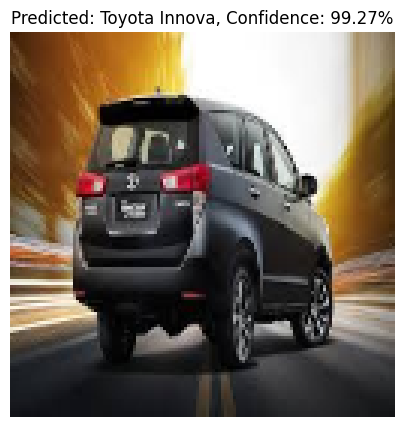

Predictions for each class:
Audi: 0.01%
Hyundai Creta: 0.13%
Mahindra Scorpio: 0.49%
Rolls Royce: 0.05%
Swift: 0.05%
Tata Safari: 0.01%
Toyota Innova: 99.27%




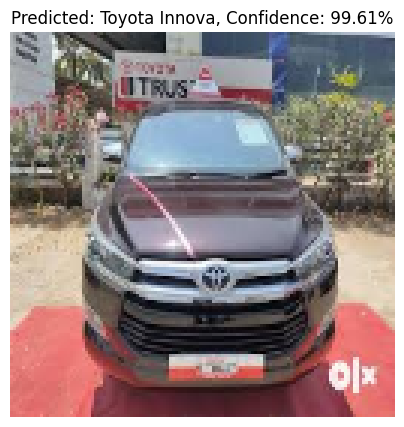

Predictions for each class:
Audi: 0.00%
Hyundai Creta: 0.01%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.00%
Swift: 0.37%
Tata Safari: 0.00%
Toyota Innova: 99.61%




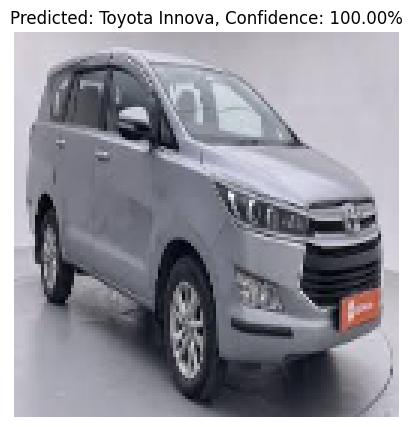

Predictions for each class:
Audi: 0.00%
Hyundai Creta: 0.00%
Mahindra Scorpio: 0.00%
Rolls Royce: 0.00%
Swift: 0.00%
Tata Safari: 0.00%
Toyota Innova: 100.00%




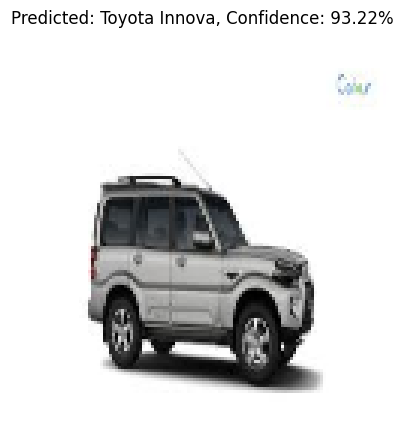

Predictions for each class:
Audi: 0.07%
Hyundai Creta: 1.32%
Mahindra Scorpio: 2.76%
Rolls Royce: 0.08%
Swift: 0.07%
Tata Safari: 2.49%
Toyota Innova: 93.22%




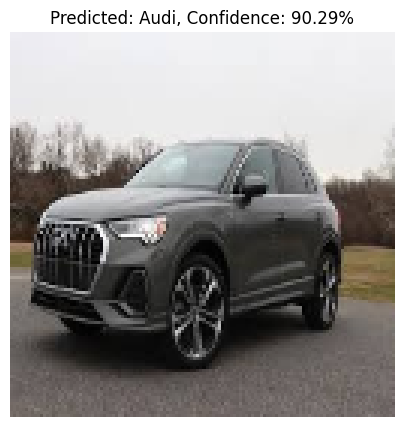

Predictions for each class:
Audi: 90.29%
Hyundai Creta: 0.00%
Mahindra Scorpio: 0.00%
Rolls Royce: 9.70%
Swift: 0.00%
Tata Safari: 0.01%
Toyota Innova: 0.00%




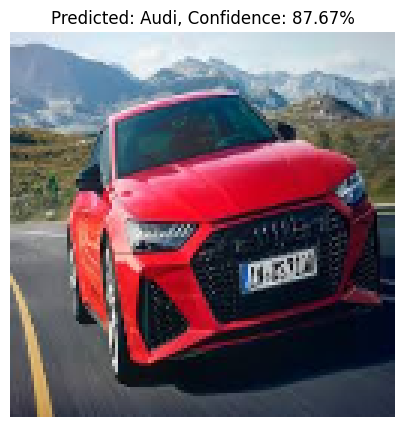

Predictions for each class:
Audi: 87.67%
Hyundai Creta: 0.24%
Mahindra Scorpio: 0.07%
Rolls Royce: 0.15%
Swift: 10.54%
Tata Safari: 1.14%
Toyota Innova: 0.18%




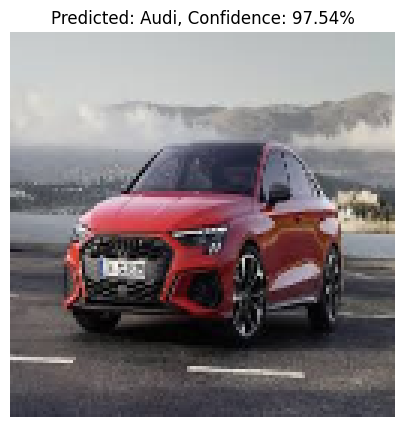

Predictions for each class:
Audi: 97.54%
Hyundai Creta: 0.01%
Mahindra Scorpio: 0.02%
Rolls Royce: 2.31%
Swift: 0.08%
Tata Safari: 0.04%
Toyota Innova: 0.00%




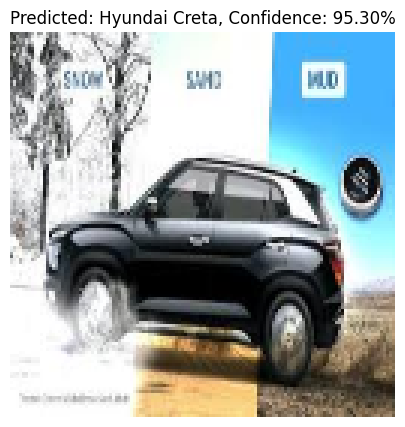

Predictions for each class:
Audi: 0.00%
Hyundai Creta: 95.30%
Mahindra Scorpio: 0.12%
Rolls Royce: 0.01%
Swift: 0.00%
Tata Safari: 0.17%
Toyota Innova: 4.40%




In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

def plot_predictions(images, labels, predictions, label_encoder, num_images_to_show=30):
    num_images_to_show = min(num_images_to_show, len(images))
    
    indices = np.random.choice(len(images), num_images_to_show, replace=False)
    
    for idx in indices:
        img = images[idx].copy()
        if img.dtype != np.uint8:
            img = (img * 255).astype('uint8')
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

        pred_label = label_encoder.inverse_transform([labels[idx]])[0]
        confidence = np.max(predictions[idx])

        plt.figure(figsize=(5, 5))
        plt.imshow(img)
        plt.title(f"Predicted: {pred_label}, Confidence: {confidence*100:.2f}%")
        plt.axis('off')
        plt.show()

        class_predictions = predictions[idx]
        print("Predictions for each class:")
        for i, conf in enumerate(class_predictions):
            class_name = label_encoder.inverse_transform([i])[0]
            print(f"{class_name}: {conf*100:.2f}%")
        print("\n") 

plot_predictions(test_images, predicted_classes, predictions, label_encoder, num_images_to_show=20)
